# Psychologist model which will be used for psychologist AI model 😰😆
The work of Nurbol Sembayev from SE-2301, Liana Smatulla and Gaziza Tanirbergen from SE-2302

# Installation

In [ ]:
!pip install -q transformers datasets scikit-learn torch tensorflow joblib matplotlib seaborn fastapi uvicorn nest_asyncio pyngrok tqdm

# Training and Preparing

In [ ]:
import os, time, json, threading
from pathlib import Path
from typing import List
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import joblib
from tqdm.auto import tqdm

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, hamming_loss, average_precision_score

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPool1D

In [ ]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import nest_asyncio
from pyngrok import ngrok
import uvicorn

In [ ]:
ds = load_dataset("SetFit/go_emotions")
train_df = pd.DataFrame(ds["train"])
test_df = pd.DataFrame(ds["test"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/236 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/19.2M [00:00<?, ?B/s]

validation.jsonl:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

TEXT_COL = "text"
label_cols = [c for c in train_df.columns if c != TEXT_COL]
NUM_LABELS = len(label_cols)
print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)
print("Num labels:", NUM_LABELS, "Example labels:", label_cols[:10])

Train: (39069, 29) Val: (4341, 29) Test: (5427, 29)
Num labels: 28 Example labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment']


In [ ]:
X_train_texts = train_df[TEXT_COL].astype(str).tolist()
X_val_texts = val_df[TEXT_COL].astype(str).tolist()
X_test_texts = test_df[TEXT_COL].astype(str).tolist()

y_train = train_df[label_cols].values.astype(int)
y_val = val_df[label_cols].values.astype(int)
y_test = test_df[label_cols].values.astype(int)

In [ ]:
os.makedirs("artifacts", exist_ok=True)
joblib.dump(label_cols, "artifacts/label_cols.pkl")

['artifacts/label_cols.pkl']

# Metric helpers

---



In [ ]:
def multi_label_metrics(y_true, y_pred_bin, y_scores=None):
    out = {}
    p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred_bin, average="micro", zero_division=0)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred_bin, average="macro", zero_division=0)
    out.update({
        "precision_micro": float(p_micro), "recall_micro": float(r_micro), "f1_micro": float(f1_micro),
        "precision_macro": float(p_macro), "recall_macro": float(r_macro), "f1_macro": float(f1_macro),
        "subset_accuracy": float(accuracy_score(y_true, y_pred_bin)),
        "hamming_loss": float(hamming_loss(y_true, y_pred_bin))
    })
    if y_scores is not None:
        try:
            out["roc_auc_micro"] = float(roc_auc_score(y_true, y_scores, average="micro"))
        except Exception:
            out["roc_auc_micro"] = np.nan
        try:
            out["avg_precision_micro"] = float(average_precision_score(y_true, y_scores, average="micro"))
        except Exception:
            out["avg_precision_micro"] = np.nan
    return out

In [ ]:
def print_metrics(metrics):
    for k,v in metrics.items():
        if isinstance(v, float):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")

# Classical Model

In [ ]:
print("Fitting TF-IDF...")
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2), stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train_texts)
X_val_tfidf = tfidf.transform(X_val_texts)
X_test_tfidf = tfidf.transform(X_test_texts)
joblib.dump(tfidf, "artifacts/tfidf.joblib")

Fitting TF-IDF...


['artifacts/tfidf.joblib']

In [ ]:
classical_models = {
    "naive_bayes": MultinomialNB(),
    "linear_svc": LinearSVC(max_iter=20000),
    "logistic": LogisticRegression(max_iter=2000)
}

In [ ]:
classical_results = {}

In [ ]:
for name, clf in classical_models.items():
    print(f"\nTraining {name} ...")
    t0 = time.time()
    ovr = OneVsRestClassifier(clf)
    ovr.fit(X_train_tfidf, y_train)
    train_time = time.time() - t0

    # attempt to get scores (decision_function or predict_proba)
    scores = None
    try:
        if hasattr(ovr, "decision_function"):
            scores = ovr.decision_function(X_test_tfidf)
        elif hasattr(ovr, "predict_proba"):
            scores = ovr.predict_proba(X_test_tfidf)
    except Exception:
        scores = None

    preds = ovr.predict(X_test_tfidf)
    metrics = multi_label_metrics(y_test, preds, scores)
    metrics["train_time_s"] = train_time
    classical_results[name] = {"model": ovr, "metrics": metrics, "scores": scores}
    joblib.dump(ovr, f"artifacts/{name}_ovr.joblib")
    print(f"{name} metrics:")
    print_metrics(metrics)


Training naive_bayes ...
naive_bayes metrics:
precision_micro: 0.7525
recall_micro: 0.0360
f1_micro: 0.0688
precision_macro: 0.2334
recall_macro: 0.0128
f1_macro: 0.0224
subset_accuracy: 0.0370
hamming_loss: 0.0406
roc_auc_micro: 0.8313
avg_precision_micro: 0.3263
train_time_s: 0.7287

Training linear_svc ...
linear_svc metrics:
precision_micro: 0.6459
recall_micro: 0.3724
f1_micro: 0.4724
precision_macro: 0.5626
recall_macro: 0.2615
f1_macro: 0.3340
subset_accuracy: 0.3392
hamming_loss: 0.0346
roc_auc_micro: 0.8858
avg_precision_micro: 0.4875
train_time_s: 14.1998

Training logistic ...
logistic metrics:
precision_micro: 0.7101
recall_micro: 0.2879
f1_micro: 0.4097
precision_macro: 0.6464
recall_macro: 0.1742
f1_macro: 0.2382
subset_accuracy: 0.2766
hamming_loss: 0.0346
roc_auc_micro: 0.9213
avg_precision_micro: 0.5202
train_time_s: 29.0763


# L1. LSTM

In [ ]:
MAX_WORDS = 30000
MAX_LEN = 128
EMBED_DIM = 128

In [ ]:
print("\nTokenizing for LSTM...")
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)
joblib.dump(tokenizer, "artifacts/lstm_tokenizer.joblib")


Tokenizing for LSTM...


['artifacts/lstm_tokenizer.joblib']

In [ ]:
def texts_to_padded(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")


In [ ]:
X_train_seq = texts_to_padded(X_train_texts)
X_val_seq = texts_to_padded(X_val_texts)
X_test_seq = texts_to_padded(X_test_texts)

In [ ]:
print("Building LSTM model...")
lstm_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(NUM_LABELS, activation="sigmoid")
])
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.summary()

Building LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 3
BATCH = 64
t0 = time.time()
history = lstm_model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), epochs=EPOCHS, batch_size=BATCH, verbose=1)
lstm_train_time = time.time() - t0

Epoch 1/3
611/611 ━━━━━━━━━━━━━━━━━━━━ 60s 57ms/step - accuracy: 0.2810 - loss: 0.1884 - val_accuracy: 0.4522 - val_loss: 0.1198
Epoch 2/3
611/611 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4604 - loss: 0.1191 - val_accuracy: 0.4950 - val_loss: 0.1070
Epoch 3/3
611/611 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5185 - loss: 0.1019 - val_accuracy: 0.5086 - val_loss: 0.1041


In [ ]:
y_scores_lstm = lstm_model.predict(X_test_seq, batch_size=256)
y_pred_lstm = (y_scores_lstm >= 0.5).astype(int)
metrics_lstm = multi_label_metrics(y_test, y_pred_lstm, y_scores_lstm)
metrics_lstm["train_time_s"] = lstm_train_time
print("\nLSTM metrics:")
print_metrics(metrics_lstm)
lstm_model.save("artifacts/lstm_model.h5")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step



LSTM metrics:
precision_micro: 0.6878
recall_micro: 0.3669
f1_micro: 0.4785
precision_macro: 0.3917
recall_macro: 0.2008
f1_macro: 0.2347
subset_accuracy: 0.3543
hamming_loss: 0.0333
roc_auc_micro: 0.9148
avg_precision_micro: 0.5340
train_time_s: 87.6912


# L5. BERT

In [ ]:
print("\nPreparing BERT tokenization and datasets...")
tokenizer_bert = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


Preparing BERT tokenization and datasets...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def tokenize_texts(texts, max_len=128):
    return tokenizer_bert(texts, padding=True, truncation=True, max_length=max_len)

train_enc = tokenize_texts(X_train_texts)
val_enc = tokenize_texts(X_val_texts)
test_enc = tokenize_texts(X_test_texts)

In [ ]:
class TorchMultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx]).float()
        return item

In [ ]:
train_dataset = TorchMultiLabelDataset(train_enc, y_train)
val_dataset = TorchMultiLabelDataset(val_enc, y_val)
test_dataset = TorchMultiLabelDataset(test_enc, y_test)

In [ ]:
print("Loading DistilBERT model...")
model_bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                                 problem_type="multi_label_classification",
                                                                 num_labels=NUM_LABELS)

Loading DistilBERT model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, IntervalStrategy

training_args = TrainingArguments(
    output_dir="artifacts/bert_out",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=1,   # increase if you have GPU/time
    weight_decay=0.01,
    logging_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

In [ ]:
def compute_metrics_for_trainer(p):
    logits = p.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs >= 0.5).astype(int)
    m = multi_label_metrics(p.label_ids, preds, probs)
    return {"f1_micro": m["f1_micro"], "roc_auc_micro": m.get("roc_auc_micro", np.nan)}


In [ ]:
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_for_trainer
)

In [ ]:
print("Training DistilBERT (may be slow on CPU)...")
t0 = time.time()
trainer.train()
bert_train_time = time.time() - t0
print(f"DistilBERT training time: {bert_train_time:.1f}s")

Training DistilBERT (may be slow on CPU)...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gaztan0522 (gaztan0522-aitu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Micro,Roc Auc Micro
1,0.093000,0.088942,0.518641,0.947688


DistilBERT training time: 708.5s


In [ ]:
raw_pred = trainer.predict(test_dataset)
logits = raw_pred.predictions
probs_bert = torch.sigmoid(torch.tensor(logits)).numpy()
preds_bert = (probs_bert >= 0.5).astype(int)
metrics_bert = multi_label_metrics(y_test, preds_bert, probs_bert)
metrics_bert["train_time_s"] = bert_train_time
print("\nDistilBERT metrics:")
print_metrics(metrics_bert)


DistilBERT metrics:
precision_micro: 0.7498
recall_micro: 0.3977
f1_micro: 0.5197
precision_macro: 0.4887
recall_macro: 0.2317
f1_macro: 0.2772
subset_accuracy: 0.3882
hamming_loss: 0.0306
roc_auc_micro: 0.9490
avg_precision_micro: 0.6225
train_time_s: 708.4991


In [ ]:
model_bert.save_pretrained("artifacts/distilbert_model")
tokenizer_bert.save_pretrained("artifacts/distilbert_model")

('artifacts/distilbert_model/tokenizer_config.json',
 'artifacts/distilbert_model/special_tokens_map.json',
 'artifacts/distilbert_model/vocab.txt',
 'artifacts/distilbert_model/added_tokens.json',
 'artifacts/distilbert_model/tokenizer.json')

# Summary

In [ ]:
results = {}

In [ ]:
for k,v in classical_results.items():
    results[k] = v["metrics"]
# lstm & bert
results["lstm"] = metrics_lstm
results["distilbert"] = metrics_bert

df_results = pd.DataFrame([{ "model": m, **metrics } for m, metrics in results.items()]).set_index("model")
display(df_results)

,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,subset_accuracy,hamming_loss,roc_auc_micro,avg_precision_micro,train_time_s
model,,,,,,,,,,,
naive_bayes,0.752475,0.036025,0.068758,0.233400,0.012771,0.022411,0.037037,0.040643,0.831276,0.326253,0.728731
linear_svc,0.645930,0.372413,0.472439,0.562631,0.261518,0.334014,0.339230,0.034642,0.885774,0.487488,14.199773
logistic,0.710055,0.287881,0.409668,0.646378,0.174206,0.238174,0.276580,0.034556,0.921255,0.520154,29.076318
lstm,0.687796,0.366883,0.478516,0.391704,0.200785,0.234687,0.354339,0.033306,0.914832,0.534028,87.691198
distilbert,0.749777,0.397693,0.519719,0.488679,0.231733,0.277235,0.388244,0.030614,0.949000,0.622494,708.499094


<Figure size 1200x500 with 0 Axes>

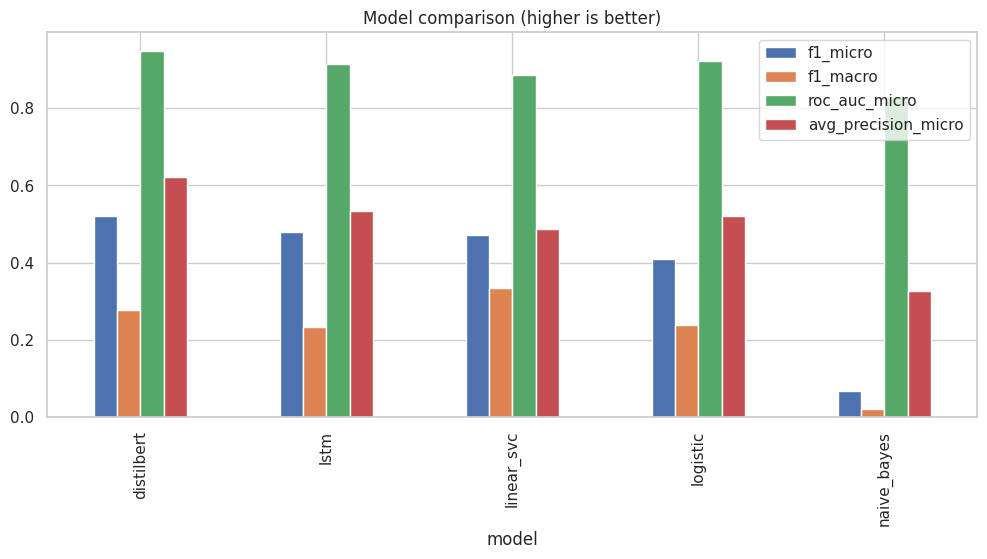

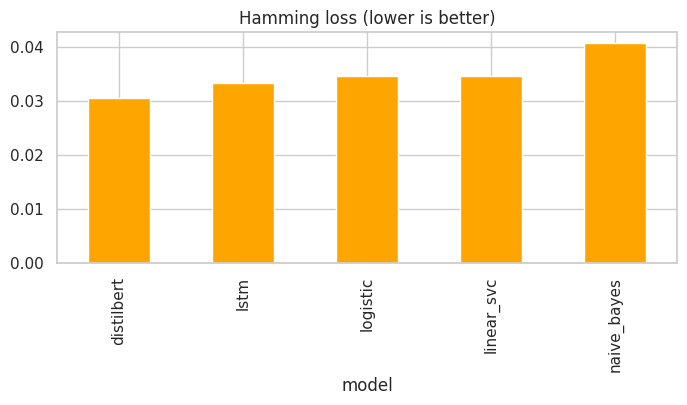

Best model by micro F1: distilbert
Summary (model : micro-F1, roc_auc_micro, train_time_s):
- naive_bayes: f1_micro=0.0688, roc_auc_micro=0.8313, train_time_s=0.7
- linear_svc: f1_micro=0.4724, roc_auc_micro=0.8858, train_time_s=14.2
- logistic: f1_micro=0.4097, roc_auc_micro=0.9213, train_time_s=29.1
- lstm: f1_micro=0.4785, roc_auc_micro=0.9148, train_time_s=87.7
- distilbert: f1_micro=0.5197, roc_auc_micro=0.9490, train_time_s=708.5


In [ ]:
metrics_to_plot = ["f1_micro", "f1_macro", "roc_auc_micro", "avg_precision_micro"]
plt.figure(figsize=(12,5))
plot_df = df_results[metrics_to_plot].sort_values("f1_micro", ascending=False)
plot_df.plot(kind="bar", figsize=(12,5))
plt.title("Model comparison (higher is better)")
plt.show()

plt.figure(figsize=(8,3))
df_results["hamming_loss"].sort_values().plot(kind="bar", color="orange")
plt.title("Hamming loss (lower is better)")
plt.show()

best_model_name = df_results["f1_micro"].idxmax()
print(f"Best model by micro F1: {best_model_name}")
print("Summary (model : micro-F1, roc_auc_micro, train_time_s):")
for m in df_results.index:
    print(f"- {m}: f1_micro={df_results.loc[m,'f1_micro']:.4f}, roc_auc_micro={df_results.loc[m,'roc_auc_micro']:.4f}, train_time_s={df_results.loc[m,'train_time_s']:.1f}")

# Per-label threshold tuning

In [ ]:
def tune_thresholds(y_true_val, y_scores_val, steps=50):
    n_labels = y_scores_val.shape[1]
    best_ts = np.full(n_labels, 0.5)
    for i in range(n_labels):
        best_f = -1
        best_t = 0.5
        scores = y_scores_val[:, i]
        for t in np.linspace(0.05, 0.95, steps):
            preds = (scores >= t).astype(int)
            p, r, f, _ = precision_recall_fscore_support(y_true_val[:, i], preds, average="binary", zero_division=0)
            if f > best_f:
                best_f = f
                best_t = t
        best_ts[i] = best_t
    return best_ts

In [ ]:
best_scores_val = None
best_model_obj = None
if best_model_name in ["distilbert"]:
    # compute val scores via trainer
    val_raw = trainer.predict(val_dataset)
    logits_val = val_raw.predictions
    best_scores_val = torch.sigmoid(torch.tensor(logits_val)).numpy()
    best_model_obj = ("distilbert", "artifacts/distilbert_model")
elif best_model_name == "lstm":
    best_scores_val = lstm_model.predict(X_val_seq, batch_size=256)
    best_model_obj = ("lstm", "artifacts/lstm_model.h5")
else:
    sk = joblib.load(f"artifacts/{best_model_name}_ovr.joblib")
    try:
        if hasattr(sk, "decision_function"):
            best_scores_val = sk.decision_function(X_val_tfidf)
        else:
            best_scores_val = sk.predict_proba(X_val_tfidf)
    except Exception:
        best_scores_val = None
    best_model_obj = (best_model_name, f"artifacts/{best_model_name}_ovr.joblib")

In [ ]:
if best_scores_val is not None:
    print("Tuning per-label thresholds on validation set...")
    per_label_thresholds = tune_thresholds(y_val, np.array(best_scores_val))
    joblib.dump(per_label_thresholds, "artifacts/per_label_thresholds.pkl")
    print("Saved per-label thresholds (sample first 10):", per_label_thresholds[:10])
else:
    per_label_thresholds = None
    print("No continuous scores available for threshold tuning for selected model.")


Tuning per-label thresholds on validation set...
Saved per-label thresholds (sample first 10): [0.30714286 0.34387755 0.38061224 0.17857143 0.12346939 0.10510204
 0.21530612 0.34387755 0.12346939 0.12346939]


# Save final artifacts for deployment



In [ ]:
print("Best model:", best_model_name)
if best_model_name in ["naive_bayes", "linear_svc", "logistic"]:
    deployed_type = "sklearn"
    deployed_path = f"artifacts/{best_model_name}_ovr.joblib"
elif best_model_name == "lstm":
    deployed_type = "lstm"
    deployed_path = "artifacts/lstm_model.h5"
elif best_model_name == "distilbert":
    deployed_type = "distilbert"
    deployed_path = "artifacts/distilbert_model"
else:
    deployed_type = "sklearn"
    deployed_path = f"artifacts/{best_model_name}_ovr.joblib"
print("Deployed type:", deployed_type, "path:", deployed_path)

Best model: distilbert
Deployed type: distilbert path: artifacts/distilbert_model


# Deploy

In [ ]:
label_cols = joblib.load("artifacts/label_cols.pkl")

In [ ]:
if deployed_type == "sklearn":
    clf = joblib.load(deployed_path)
    tfidf = joblib.load("artifacts/tfidf.joblib")
    def predict_texts(texts, threshold=0.5):
        Xtf = tfidf.transform(texts)
        scores = None
        try:
            if hasattr(clf, "decision_function"):
                scores = clf.decision_function(Xtf)
            else:
                scores = clf.predict_proba(Xtf)
        except Exception:
            preds = clf.predict(Xtf)
            return preds, None
        preds = (np.array(scores) >= threshold).astype(int)
        return preds, np.array(scores)

elif deployed_type == "lstm":
    from tensorflow.keras.models import load_model
    lstm = load_model(deployed_path)
    tokenizer = joblib.load("artifacts/lstm_tokenizer.joblib")
    max_len = lstm.input_shape[1]
    def predict_texts(texts, threshold=0.5):
        seqs = tokenizer.texts_to_sequences(texts)
        pad = pad_sequences(seqs, maxlen=max_len, padding='post')
        scores = lstm.predict(pad)
        preds = (scores >= threshold).astype(int)
        return preds, scores

elif deployed_type == "distilbert":
    tokenizer_hf = DistilBertTokenizerFast.from_pretrained(deployed_path)
    model_hf = DistilBertForSequenceClassification.from_pretrained(deployed_path)
    model_hf.eval()
    def predict_texts(texts, threshold=0.5):
        enc = tokenizer_hf(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            out = model_hf(**enc)
            logits = out.logits
            scores = torch.sigmoid(logits).cpu().numpy()
        preds = (scores >= threshold).astype(int)
        return preds, scores

else:
    raise ValueError("Unsupported model type")


In [ ]:
if os.path.exists("artifacts/per_label_thresholds.pkl"):
    per_label_thresholds = joblib.load("artifacts/per_label_thresholds.pkl")
else:
    per_label_thresholds = None

In [ ]:
app = FastAPI(title="GoEmotions Multi-label API (best model deployed)")

class PredictRequest(BaseModel):
    text: str
    threshold: float = 0.5
    use_per_label_thresholds: bool = False

@app.post("/predict")
def predict_api(req: PredictRequest):
    text = req.text
    thr = req.threshold
    if req.use_per_label_thresholds and (per_label_thresholds is not None):
        thr_used = per_label_thresholds
    else:
        thr_used = thr
    preds, scores = predict_texts([text], threshold=thr_used)
    probs = scores.tolist()[0] if scores is not None else None
    labels_pred = [label_cols[i] for i,v in enumerate(preds[0]) if v==1]
    return {"text": text, "predicted_labels": labels_pred, "probs": probs, "threshold_used": ("per-label" if isinstance(thr_used, (list, np.ndarray)) else thr_used)}

In [ ]:
print("Starting FastAPI server with ngrok tunnel...")
nest_asyncio.apply()

# Set your ngrok authtoken here. Replace 'YOUR_NGROK_AUTH_TOKEN' with your actual token.
# You can get one from https://dashboard.ngrok.com/get-started/your-authtoken
# For better security, consider storing this as a Colab secret and accessing it via `os.environ.get('NGROK_AUTH_TOKEN')`
ngrok.set_auth_token("356sw3gpUy3oNoFbmaKZeXGOAlu_5FJX5wnaC4v6sYADofHY6")

# Change the port to avoid 'address already in use' error if a previous instance is still running
PORT = 8000
public_url = ngrok.connect(PORT).public_url
print("Public URL:", public_url)

config = uvicorn.Config(app=app, host="0.0.0.0", port=PORT, log_level="info")
s = uvicorn.Server(config=config)
t = threading.Thread(target=s.run)
t.start()

print("Server running. Example curl:")
print(f"curl -X POST {public_url}/predict -H 'Content-Type: application/json' -d '{{\"text\":\"I feel great and happy today!\",\"use_per_label_thresholds\":false}}'")

Starting FastAPI server with ngrok tunnel...
Public URL: https://aforesaid-subprofitably-gus.ngrok-free.dev
Server running. Example curl:
curl -X POST https://aforesaid-subprofitably-gus.ngrok-free.dev/predict -H 'Content-Type: application/json' -d '{"text":"I feel great and happy today!","use_per_label_thresholds":false}'


### Confusion Matrix for DistilBERT

Generating confusion matrices for each label...


INFO:     Started server process [982]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


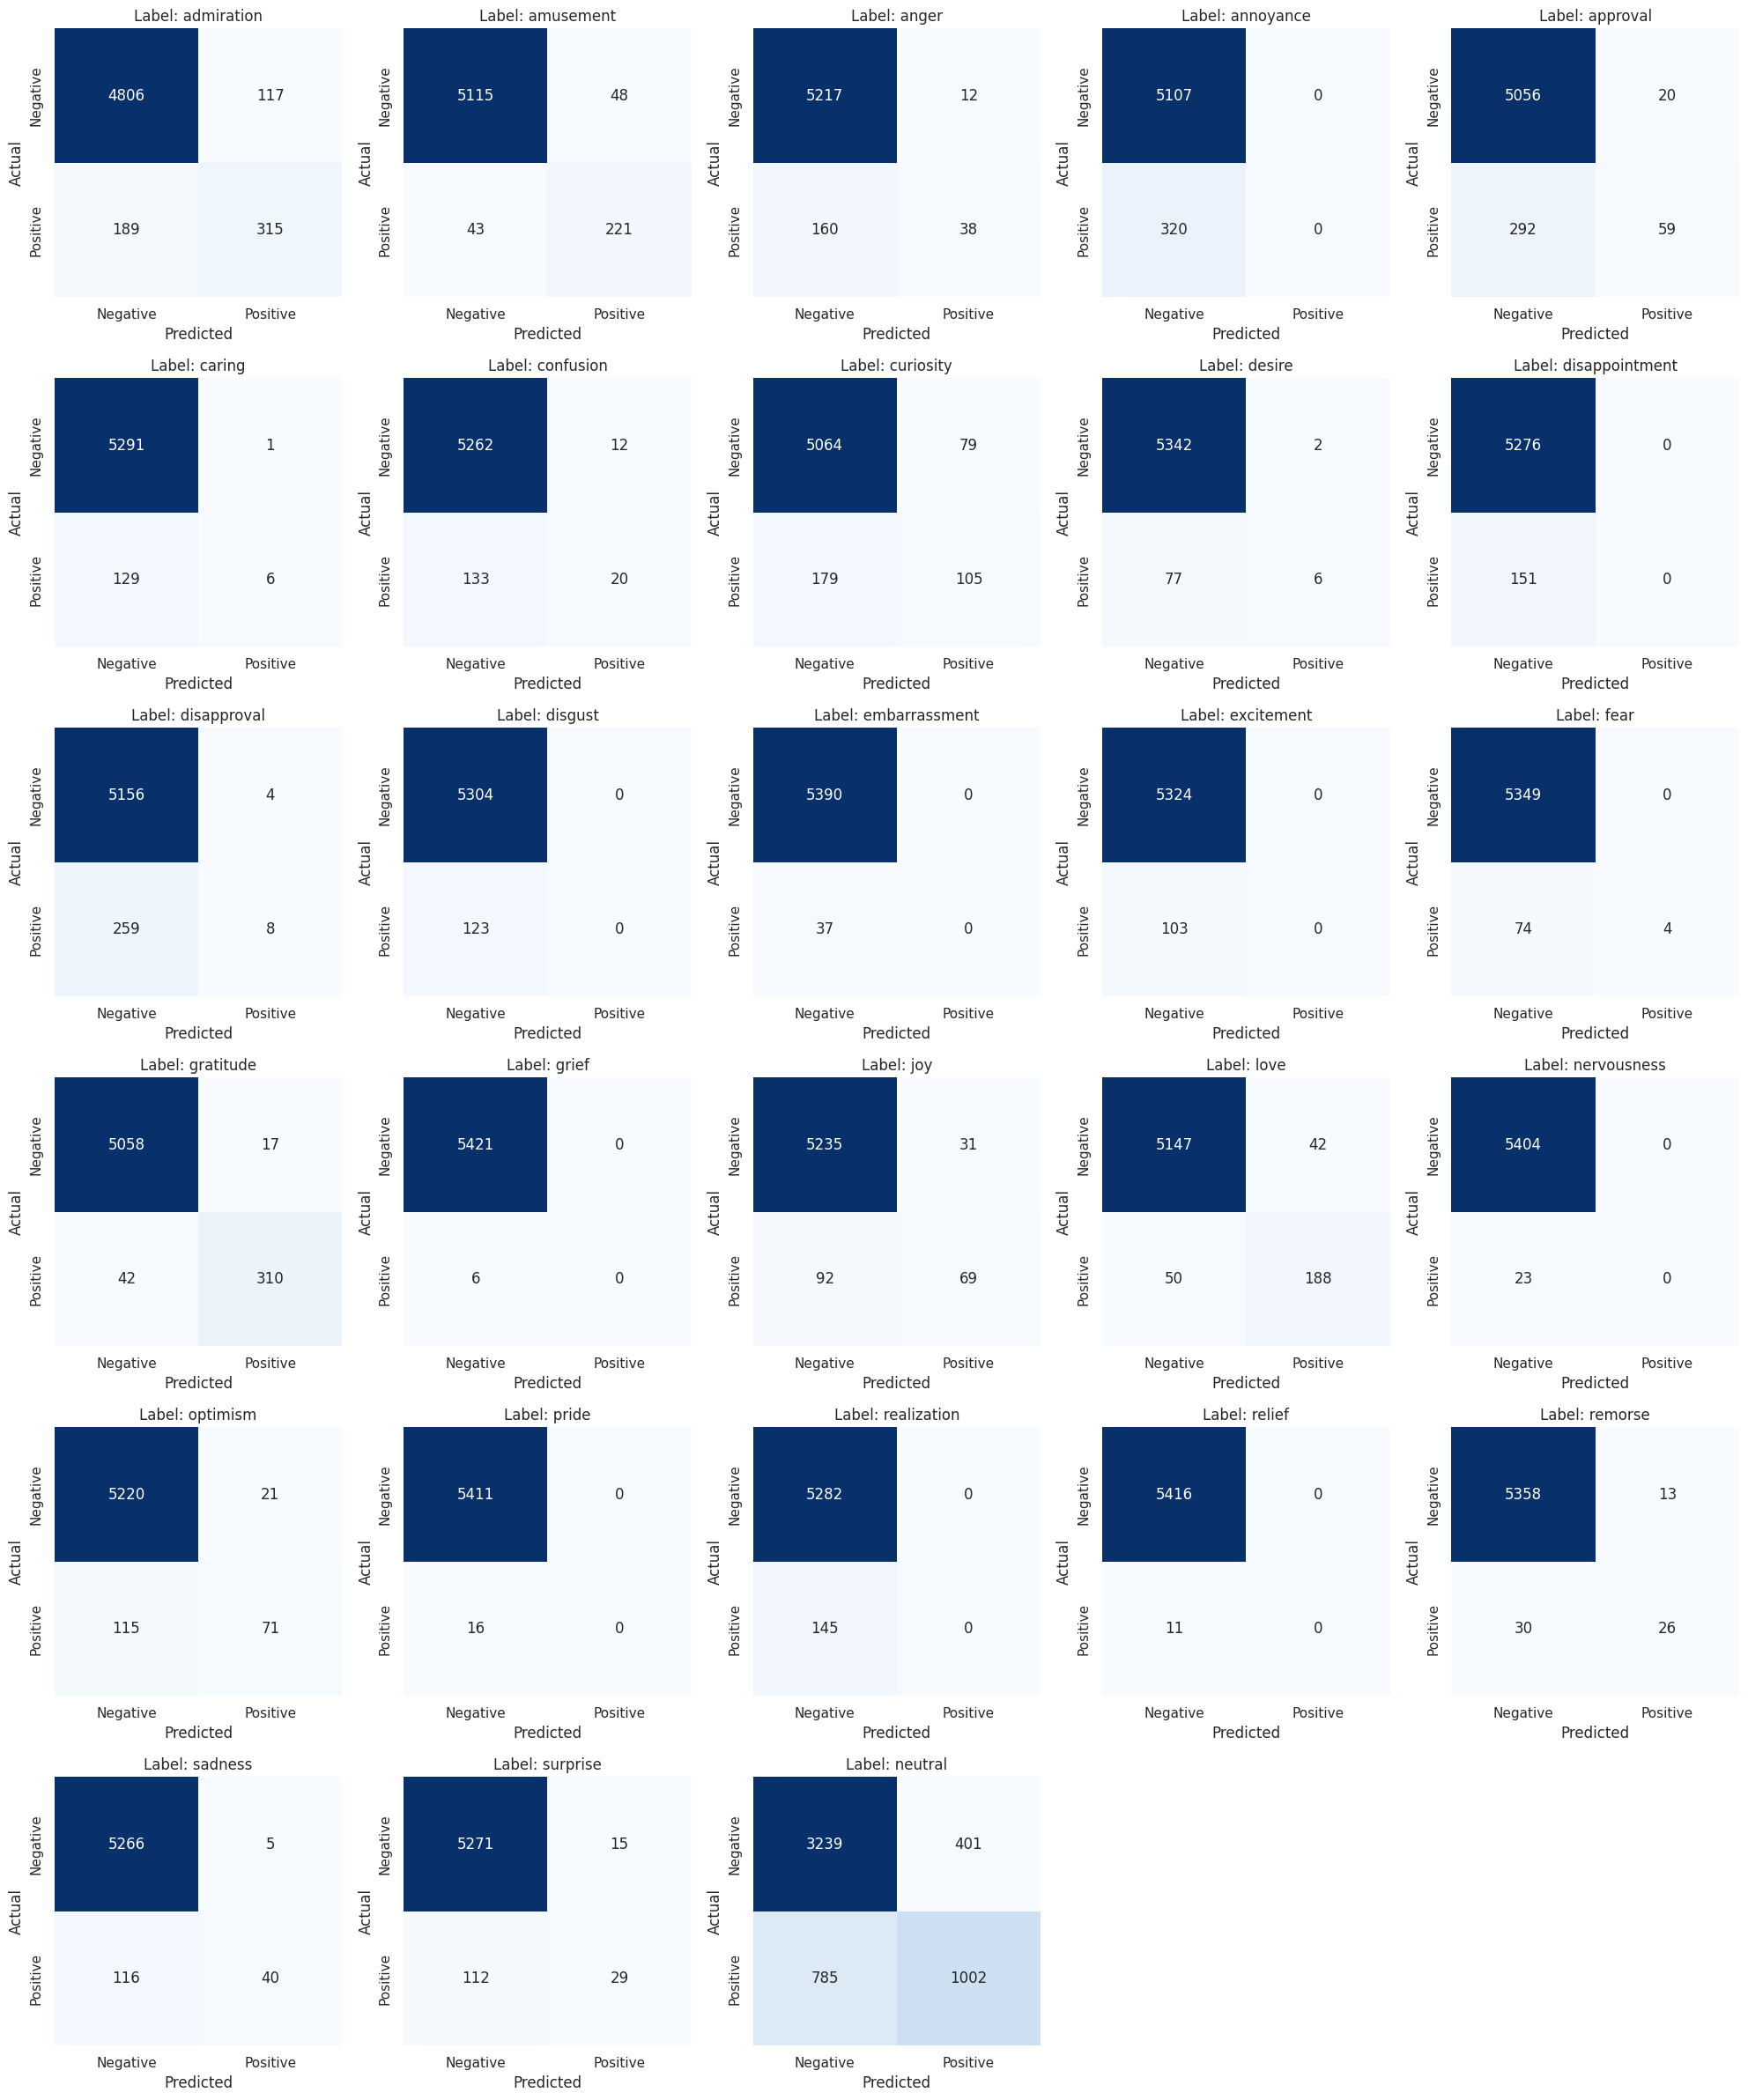

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming y_test and preds_bert are available from previous cells
# y_test is the true labels for the test set
# preds_bert are the binary predictions from the DistilBERT model

# Since it's multi-label, we can create a confusion matrix for each label
# or a aggregated one. For simplicity, let's look at it per label initially.

print("Generating confusion matrices for each label...")

num_labels = y_test.shape[1]
fig, axes = plt.subplots(nrows=int(np.ceil(num_labels/5)), ncols=5, figsize=(20, 4 * int(np.ceil(num_labels/5))))
axes = axes.flatten()

for i in range(num_labels):
    cm = confusion_matrix(y_test[:, i], preds_bert[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[i])
    axes[i].set_title(f'Label: {label_cols[i]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()